# TFG

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from IPython.display import Markdown as md
import statistics as st
import math
import seaborn as sn

### Funcions


In [3]:
# Descents del gradient

def gradient_descent(ps, pa, wp, lr, max_iteration):
    momentum = 0.9
    gamma = random.randint(-10,20)
    prev_gradient = 0
    for i in range(max_iteration):
        gamma = gamma - momentum*prev_gradient
        gradient = -2*(wp-((pow(ps,gamma))/(pow(ps,gamma)+pow(pa,gamma))))*((np.log(pa)-np.log(ps))*pow(pa,gamma)*pow(ps,gamma))/pow((pow(pa,gamma)+pow(ps,gamma)),2)
        gradient = prev_gradient*momentum - gradient*lr
        gamma = gamma - gradient
        prev_gradient = gradient
        
    return gamma

In [4]:
def read_csv_training():
    df = pd.read_csv("Dades/df_train_complete.csv")
    # df = pd.read_csv("Dades/df_train_complete.csv", skiprows = range(1, 35000), skipfooter = 30000)
    str_to_year = [int(year[0:4]) for year in df['match_id']]
    df['match_id'] = str_to_year
    
    df_winner = pd.concat([df['match_id'], df['winner_name'], df['winner_total_points_won'], df['loser_total_points_won'], df['winner_sets_won'] + df['loser_sets_won']], axis = 1, keys =  ['match_id', 'player_name', 'points_scored', 'points_allowed', 'num_sets'])
    df_loser = pd.concat([df['loser_name'], df['loser_total_points_won'], df['winner_total_points_won'], df['winner_sets_won'] + df['loser_sets_won']], axis = 1, keys =  ['player_name', 'points_scored', 'points_allowed', 'num_sets'])
    
    df_winner = df_winner.groupby('player_name').agg(['sum', 'count', 'max'])
    df_winner = df_winner.reset_index()
    df_loser = df_loser.groupby('player_name').agg(['sum', 'count'])
    df_loser = df_loser.reset_index()
    
    names = []
    year = []
    points_scored = []
    points_allowed = []
    num_matches = []
    win_percentage = []
    points_scored_set = []
    points_allowed_set = []

    for name in df_winner['player_name', '']:
        index_loser = df_loser[df_loser['player_name', '']==name].index.values
        index_winner = df_winner[df_winner['player_name', '']==name].index.values
        if len(index_loser) == 0:
            continue
        names.append(name)
        year.append(df_winner['match_id', 'max'][index_winner[0]])
        points_scored.append(df_winner['points_scored', 'sum'][index_winner[0]] + df_loser['points_scored', 'sum'][index_loser[0]])
        points_allowed.append(df_winner['points_allowed', 'sum'][index_winner[0]] + df_loser['points_allowed', 'sum'][index_loser[0]])
        num_matches.append(df_winner['points_allowed', 'count'][index_winner[0]] + df_loser['points_allowed', 'count'][index_loser[0]])
        win_percentage.append(df_winner['points_allowed', 'count'][index_winner[0]] / (df_winner['points_allowed', 'count'][index_winner[0]] + df_loser['points_allowed', 'count'][index_winner[0]])  )
        points_scored_set.append((df_winner['points_scored', 'sum'][index_winner[0]] + df_loser['points_scored', 'sum'][index_loser[0]])/(df_winner['num_sets', 'sum'][index_winner[0]] + df_loser['num_sets', 'sum'][index_loser[0]]))
        points_allowed_set.append((df_winner['points_allowed', 'sum'][index_winner[0]] + df_loser['points_allowed', 'sum'][index_loser[0]])/(df_winner['num_sets', 'sum'][index_winner[0]] + df_loser['num_sets', 'sum'][index_loser[0]]))

    df_final = pd.DataFrame(list(zip(names, year, points_scored, points_allowed, num_matches, win_percentage, points_scored_set, points_allowed_set)), columns=['player_name', 'year', 'points_scored', 'points_allowed', 'num_matches', 'win_percentage', 'points_scored_set', 'points_allowed_set'])
                            
    return df_final
    

In [5]:
def read_csv_test():
    df_test = pd.read_csv("Dades/df_test_complete.csv")

    str_to_year = [int(year[0:4]) for year in df_test['match_id']]
    df_test['match_id'] = str_to_year
#     print(len(df_test['match_id']))

    return(df_test)

In [6]:
def evaluation_gamma(exp):
    count_success = 0
    count = 0
    hits = [] # if well predicted= 1 - Bad predicted = 0
    df_test = read_csv_test()
    for index, row in df_test.iterrows():
        index_winner = df_final.index[df_final['player_name'] == row['winner_name']].tolist()
        index_loser = df_final.index[df_final['player_name'] == row['loser_name']].tolist()
        
        if index_winner and index_loser:
#             print(row['winner_name'], row['loser_name'])
            count += 1
            winner_force = pow(df_final['points_scored_set'][index_winner[0]],exp)/(pow(df_final['points_scored_set'][index_winner[0]],exp) + pow(df_final['points_allowed_set'][index_winner[0]],exp))
            loser_force = pow(df_final['points_scored_set'][index_loser[0]],exp)/(pow(df_final['points_scored_set'][index_loser[0]],exp) + pow(df_final['points_allowed_set'][index_loser[0]],exp))
            winner_prob = winner_force*(1-loser_force)/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
            loser_prob = (1-winner_force)*loser_force/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
            if winner_prob > loser_prob:
                count_success += 1
                hits.append(1)
            else:
                hits.append(0)
#     print(count)
    return(count_success/count, hits)

In [7]:
def evaluation_gamma_confident(exp):
    confidence_value = 0.25
    count_success = 0
    count = 0
    df_test = read_csv_test()
    hits = [] # if well predicted= 1 - Bad predicted = 0
    for index, row in df_test.iterrows():
        index_winner = df_final.index[df_final['player_name'] == row['winner_name']].tolist()
        index_loser = df_final.index[df_final['player_name'] == row['loser_name']].tolist()
        if index_winner and index_loser:
            winner_force = pow(df_final['points_scored_set'][index_winner[0]],exp)/(pow(df_final['points_scored_set'][index_winner[0]],exp) + pow(df_final['points_allowed_set'][index_winner[0]],exp))
            loser_force = pow(df_final['points_scored_set'][index_loser[0]],exp)/(pow(df_final['points_scored_set'][index_loser[0]],exp) + pow(df_final['points_allowed_set'][index_loser[0]],exp))
            winner_prob = winner_force*(1-loser_force)/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
            loser_prob = (1-winner_force)*loser_force/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
            if abs(loser_prob - winner_prob)>confidence_value:
                count += 1
                if winner_prob > loser_prob:
                    count_success += 1
                    hits.append(1)
                else:
                    hits.append(0)
    print(count_success)
    print(count)
    return(count_success/count, hits)  

## Cerca de Gamma

## Tot El Dataset

### MSE

In [7]:
df_final = read_csv_training()

exponents = []
for i in range(1,5):
    gradients = []
    for index, row in df_final[df_final['num_matches']>1].iterrows():
    # for index, row in df_final.iterrows():
        gradients.append(gradient_descent(row['points_scored_set'],row['points_allowed_set'],row['win_percentage'],0.05, 1000))

    exponents.append(sum(gradients)/len(gradients))
print("S'obté un exponent de ", (sum(exponents)/len(exponents)))

gamma=np.mean(exponents)

df_final = read_csv_training()

result, hits_1 = evaluation_gamma(gamma)
print('Percentatge encerts:', result)
result, hits_1 = evaluation_gamma_confident(gamma)
print("Percentatge encerts (amb confiança):", result)

S'obté un exponent de  3.9851109783744607
Percentatge encerts: 0.6052855924978687
216
268
Percentatge encerts (amb confiança): 0.8059701492537313


### LR

L'exponent trobat utilitzant aquest mètode és:  13.28497234649604
Percentatge encerts: 0.6052855924978687
1167
1731
Percentatge encerts (amb confiança): 0.6741767764298093
Mateixos resultats  False


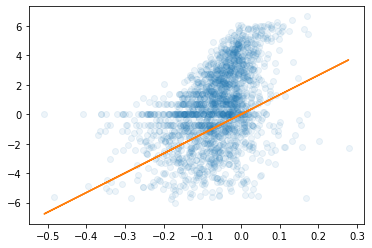

In [9]:
df_final = read_csv_training()

X = np.log(df_final['points_scored_set']/df_final['points_allowed_set']).values.reshape((-1,1))
y = np.log(df_final['win_percentage']/(1-df_final['win_percentage']))

lm = LinearRegression( fit_intercept = True).fit(X, y)
reg_coef = lm.coef_
print("L'exponent trobat utilitzant aquest mètode és: ", reg_coef[0])

plt.plot(X,y,'o',  alpha = 0.08) # Executar 
plt.plot(X, lm.coef_*X)

gamma=reg_coef[0]

result, hits_2 = evaluation_gamma(gamma)
print('Percentatge encerts:', result)
result, hits_2_1 = evaluation_gamma_confident(gamma)
print("Percentatge encerts (amb confiança):", result)

print('Mateixos resultats ', hits_1 == hits_2)

## Gamma Segons Partits Jugats

### MSE

In [10]:
df_final = read_csv_training()

num_matches = [5,10,15,20,35,50,75,100,200,400]
for match in num_matches:
    exponents = []
    for i in range(1,5):
        gradients = []
        for index, row in df_final[df_final['num_matches']>match].iterrows():
        # for index, row in df_final.iterrows():
            gradients.append(gradient_descent(row['points_scored_set'],row['points_allowed_set'],row['win_percentage'],0.05, 1000))

        exponents.append(sum(gradients)/len(gradients))

    print("Per", match, "partits, s'obté un exponent de:", np.mean(exponents), "\n")

    gamma=np.mean(exponents)

    result, hits_matches = evaluation_gamma(gamma)
    print('Percentatge encerts:', result, "\n")
    result, hits_1 = evaluation_gamma_confident(gamma)
    print("Percentatge encerts (amb confiança):", result)
    print('-----------------------------------------------------------------------------------------------')
    

Per 5 partits, s'obté un exponent de: 3.222607734824998 

Percentatge encerts: 0.6052855924978687 

116
137
Percentatge encerts (amb confiança): 0.8467153284671532
-----------------------------------------------------------------------------------------------
Per 10 partits, s'obté un exponent de: 2.5714808880256754 

Percentatge encerts: 0.6052855924978687 

34
40
Percentatge encerts (amb confiança): 0.85
-----------------------------------------------------------------------------------------------
Per 15 partits, s'obté un exponent de: 2.4081594194303637 

Percentatge encerts: 0.6052855924978687 

18
20
Percentatge encerts (amb confiança): 0.9
-----------------------------------------------------------------------------------------------
Per 20 partits, s'obté un exponent de: 2.4171216281054475 

Percentatge encerts: 0.6052855924978687 

18
20
Percentatge encerts (amb confiança): 0.9
-----------------------------------------------------------------------------------------------
Per 

### LR

L'exponent trobat utilitzant aquest mètode és:  17.797162010414382 amb un mínim de  5 partits
Percentatge encerts: 0.6047904191616766 

1312
1994
Percentatge encerts (amb confiança): 0.6579739217652959
-----------------------------------------------------------------------------------------------


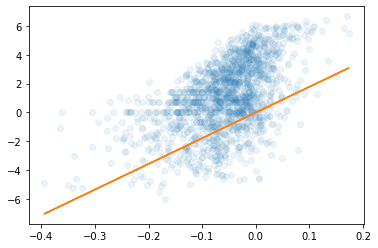

L'exponent trobat utilitzant aquest mètode és:  18.57124180931393 amb un mínim de  10 partits
Percentatge encerts: 0.6039448966812774 

1274
1939
Percentatge encerts (amb confiança): 0.6570397111913358
-----------------------------------------------------------------------------------------------


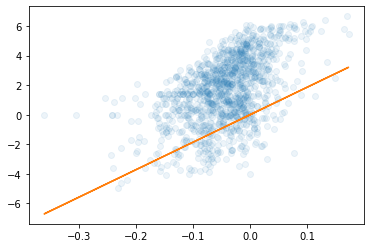

L'exponent trobat utilitzant aquest mètode és:  18.63360815443247 amb un mínim de  15 partits
Percentatge encerts: 0.6029315960912052 

1210
1844
Percentatge encerts (amb confiança): 0.6561822125813449
-----------------------------------------------------------------------------------------------


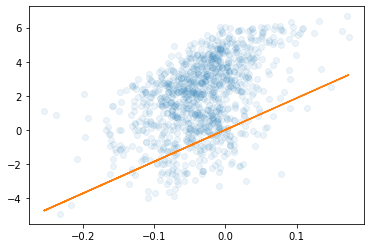

L'exponent trobat utilitzant aquest mètode és:  17.909967272883158 amb un mínim de  20 partits
Percentatge encerts: 0.6037604456824512 

1080
1629
Percentatge encerts (amb confiança): 0.6629834254143646
-----------------------------------------------------------------------------------------------


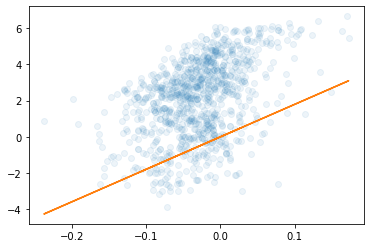

L'exponent trobat utilitzant aquest mètode és:  17.037749745463646 amb un mínim de  35 partits
Percentatge encerts: 0.6044254658385093 

909
1357
Percentatge encerts (amb confiança): 0.6698599852616065
-----------------------------------------------------------------------------------------------


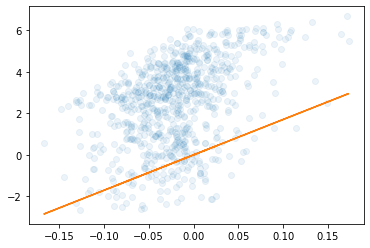

L'exponent trobat utilitzant aquest mètode és:  15.861756820549276 amb un mínim de  50 partits
Percentatge encerts: 0.6023897816234034 

792
1174
Percentatge encerts (amb confiança): 0.6746166950596252
-----------------------------------------------------------------------------------------------


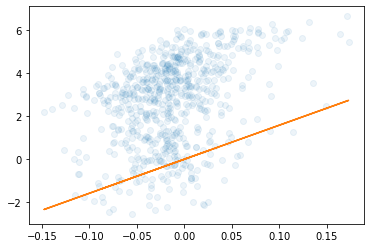

L'exponent trobat utilitzant aquest mètode és:  15.261776157829022 amb un mínim de  75 partits
Percentatge encerts: 0.610152784622967 

668
980
Percentatge encerts (amb confiança): 0.6816326530612244
-----------------------------------------------------------------------------------------------


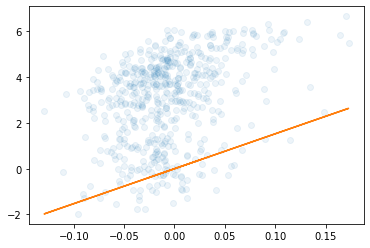

L'exponent trobat utilitzant aquest mètode és:  15.435886547527222 amb un mínim de  100 partits
Percentatge encerts: 0.6166484118291348 

629
921
Percentatge encerts (amb confiança): 0.6829533116178067
-----------------------------------------------------------------------------------------------


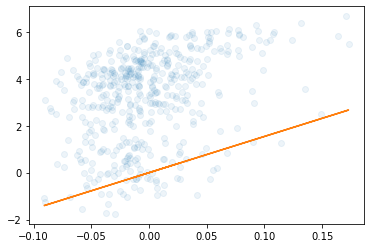

L'exponent trobat utilitzant aquest mètode és:  11.518185126173181 amb un mínim de  200 partits
Percentatge encerts: 0.6333012512030799 

356
466
Percentatge encerts (amb confiança): 0.7639484978540773
-----------------------------------------------------------------------------------------------


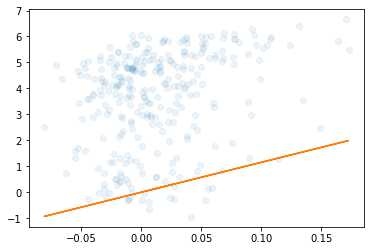

L'exponent trobat utilitzant aquest mètode és:  10.776034466108054 amb un mínim de  400 partits
Percentatge encerts: 0.6511627906976745 

94
124
Percentatge encerts (amb confiança): 0.7580645161290323
-----------------------------------------------------------------------------------------------


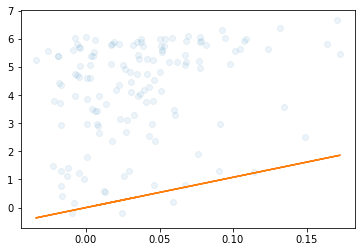

In [11]:
df_final = read_csv_training()

num_matches = [5,10,15,20,35,50,75,100,200,400]
for match in num_matches:
    df_final = df_final[df_final['num_matches']>match]
    
    X = np.log(df_final['points_scored_set']/df_final['points_allowed_set']).values.reshape((-1,1))
    y = np.log(df_final['win_percentage']/(1-df_final['win_percentage']))

    lm = LinearRegression( fit_intercept = True).fit(X, y)
    reg_coef = lm.coef_
    print("L'exponent trobat utilitzant aquest mètode és: ", reg_coef[0], "amb un mínim de ", match, "partits")
    
    result, hits_matches = evaluation_gamma(reg_coef[0])
    print('Percentatge encerts:', result, "\n")
    result, hits_1 = evaluation_gamma_confident(reg_coef[0])
    print("Percentatge encerts (amb confiança):", result)
    print('-----------------------------------------------------------------------------------------------')

    plt.plot(X,y,'o', alpha = 0.08) # Executar 
    plt.plot(X, lm.coef_*X)
    plt.show()

### Per Anys

In [13]:
# Intervals d'anys: Cada 5: 1991-1996-2001-2006-2011-2016

df_final = read_csv_training()

years = [1991, 1996, 2001, 2006, 2011, 2016]
years = [2011, 2016]

for j in range(len(years) - 1):
    df_final = read_csv_training()
    df_final[(df_final['year'] >= years[j]) & (df_final['year'] < years[j + 1])]
    
    exponents = []
    for i in range(1,5):
        gradients = []
        for index, row in df_final[df_final['num_matches']>1].iterrows():
            gradients.append(gradient_descent(row['points_scored_set'],row['points_allowed_set'],row['win_percentage'],0.05, 1000))
        
        exponents.append(np.mean(gradients))
#         gamma.append(sum(gradients)/len(gradients))
    print("S'obté un exponent de ", (sum(gradients)/len(gradients)), "entre els anys", years[j], "-", years[j+1])

    gamma=np.mean(exponents)

    result, hits_matches = evaluation_gamma(gamma)
    print('Percentatge encerts:', result, "\n")
    result, hits_1 = evaluation_gamma_confident(gamma)
    print("Percentatge encerts (amb confiança):", result)
    print('-----------------------------------------------------------------------------------------------')
    

S'obté un exponent de  4.0412331298638575 entre els anys 2011 - 2016
Percentatge encerts: 0.6052855924978687 

216
268
Percentatge encerts (amb confiança): 0.8059701492537313
-----------------------------------------------------------------------------------------------


L'exponent trobat utilitzant aquest mètode és:  8.460882456630884 entre els anys  2011 - 2016
[8.46088246]
Percentatge encerts: 0.5333333333333333 

5
10
Percentatge encerts (amb confiança): 0.5
-----------------------------------------------------------------------------------------------


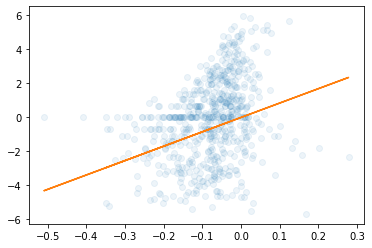

In [14]:
# df_final = read_csv_training()

years = [1991, 1996, 2001, 2006, 2011, 2016]
years = [2011, 2016]

for j in range(len(years) - 1):
    df_final = read_csv_training()
    df_final = df_final[(df_final['year'] >= years[j]) & (df_final['year'] < years[j + 1])]
    
    X = np.log(df_final['points_scored_set']/df_final['points_allowed_set']).values.reshape((-1,1))
    y = np.log(df_final['win_percentage']/(1-df_final['win_percentage']))

    lm = LinearRegression( fit_intercept = True).fit(X, y)
    reg_coef = lm.coef_
    print("L'exponent trobat utilitzant aquest mètode és: ", reg_coef[0], "entre els anys ", years[j], "-", years[j+1])
    
    print(reg_coef)
    result, hits_matches = evaluation_gamma(reg_coef)
    print('Percentatge encerts:', result, "\n")
    result, hits_1 = evaluation_gamma_confident(reg_coef)
    print("Percentatge encerts (amb confiança):", result)
    print('-----------------------------------------------------------------------------------------------')

    plt.plot(X,y,'o', alpha = 0.08) # Executar 
    plt.plot(X, lm.coef_*X)
    plt.show()   

### Gamma inside tournament

#### Tercer Partit

In [8]:
df = pd.read_csv("Dades/df_train_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
gammes = []
df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 2]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 2:
            pass
    except:
        pass
    
    winner_wp = 1
    loser_wp = 2/3
    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-2:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-2:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-2:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-2:])
    except:
        pass
    
    gamma_1 = gradient_descent(winner_points_scored, winner_points_allowed, winner_wp, 0.05, 1000)  #(ps, pa, wp, lr, max_iteration)
    gamma_2 = gradient_descent(loser_points_scored, loser_points_allowed, loser_wp, 0.05, 1000)
    
    if math.isnan(gamma_1) == False and math.isnan(gamma_2) == False: # Arreglar això
        gammes += [gamma_1, gamma_2]
        
print("Pel tercer partit s'obté la següent gamma:", np.mean(gammes))
                   
# Evaluació De la Gamma
gamma = np.mean(gammes)
df = pd.read_csv("Dades/df_test_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
count_success = 0
count_confidence = 0
count_success_confidence = 0

hits = []
hits_confidence = []

confidence_value = 0.25

df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 2]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 2:
            pass
    except:
        pass
    
    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-2:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-2:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-2:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-2:])
    except:
        pass
    
    winner_force =  pow(winner_points_scored,gamma)/(pow(winner_points_scored,gamma) + pow(winner_points_allowed,gamma))
    loser_force = pow(loser_points_scored,gamma)/(pow(loser_points_scored,gamma) + pow(loser_points_allowed,gamma))
    winner_prob = winner_force*(1-loser_force)/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    loser_prob = (1-winner_force)*loser_force/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    
    count += 1
    if winner_prob > loser_prob:
        hits.append(1)
        count_success += 1
    else:
        hits.append(0)
    
    
    if abs(loser_prob - winner_prob)>confidence_value:
        count_confidence += 1
        if winner_prob > loser_prob:
            count_success_confidence += 1
            hits_confidence.append(1)
        else:
            hits_confidence.append(0)
        
    
    
print("Pel tercer Partit s'obté un percentatge d'encert del:", count_success/count, "%")
try: 
    print("Pel tercer Partit s'obté un percentatge d'encert amb confiança del:", count_success_confidence/count_confidence, "%")
except:
    pass
print(count)
print(count_confidence)
    

C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3051936982.py:9: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3051936982.py:9: RuntimeWarning: invalid value encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3051936982.py:10: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3051936982.py:10: RuntimeWarning: invalid value encountered in true_divide
  df_streak['loser_total_points_wo

Pel tercer partit s'obté la següent gamma: 9.102505701109235


C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3051936982.py:53: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3051936982.py:54: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3051936982.py:86: RuntimeWarning: invalid value encountered in double_scalars
  loser_force = pow(loser_points_scored,gamma)/(pow(loser_points_scored,gamma) + pow(loser_points_allowed,gamma))


Pel tercer Partit s'obté un percentatge d'encert del: 0.5133470225872689 %
Pel tercer Partit s'obté un percentatge d'encert amb confiança del: 0.543661971830986 %
487
355


#### 4rt Partit

In [13]:
df = pd.read_csv("Dades/df_train_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
gammes = []
df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 3]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 3:
            pass
    except:
        pass
    
    winner_wp = 1
    loser_wp = 3/4
    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-3:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-3:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-3:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-3:])
    except:
        pass
    
    gamma_1 = gradient_descent(winner_points_scored, winner_points_allowed, winner_wp, 0.05, 1000)  #(ps, pa, wp, lr, max_iteration)
    gamma_2 = gradient_descent(loser_points_scored, loser_points_allowed, loser_wp, 0.05, 1000)
    
    if math.isnan(gamma_1) == False and math.isnan(gamma_2) == False: # Arreglar això
        gammes += [gamma_1, gamma_2]
    
print("Pel quart partit s'obté la següent gamma:", np.mean(gammes))

gamma = np.mean(gammes)
df = pd.read_csv("Dades/df_test_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
count_success = 0
count_confidence = 0
count_success_confidence = 0

hits = []
hits_confidence = []

confidence_value = 0.25

df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 3]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 3:
            pass
    except:
        pass

    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-3:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-3:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-3:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-3:])
    except:
        pass
    
    winner_force =  pow(winner_points_scored,gamma)/(pow(winner_points_scored,gamma) + pow(winner_points_allowed,gamma))
    loser_force = pow(loser_points_scored,gamma)/(pow(loser_points_scored,gamma) + pow(loser_points_allowed,gamma))
    winner_prob = winner_force*(1-loser_force)/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    loser_prob = (1-winner_force)*loser_force/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    
    count += 1
    if winner_prob > loser_prob:
        hits.append(1)
        count_success += 1
    else:
        hits.append(0)
    
    if abs(loser_prob - winner_prob)>confidence_value:
        count_confidence += 1
        if winner_prob > loser_prob:
            count_success_confidence += 1
            hits_confidence.append(1)
        else:
            hits_confidence.append(0)
            
            
print("Pel quart Partit s'obté un percentatge d'encert del:", count_success/count, "%")
try: 
    print("Pel quart Partit s'obté un percentatge d'encert amb confiança del:", count_success_confidence/count_confidence, "%")
except:
    pass
print(count)
print(count_confidence)

C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3169489342.py:9: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3169489342.py:9: RuntimeWarning: invalid value encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3169489342.py:10: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3169489342.py:10: RuntimeWarning: invalid value encountered in true_divide
  df_streak['loser_total_points_wo

Pel quart partit s'obté la següent gamma: 9.93441648959629


C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3169489342.py:52: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/3169489342.py:53: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]


Pel quart Partit s'obté un percentatge d'encert del: 0.48826291079812206 %
Pel quart Partit s'obté un percentatge d'encert amb confiança del: 0.4934210526315789 %
213
152


#### Cinquè Partit

In [14]:
df = pd.read_csv("Dades/df_train_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
gammes = []
df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 4]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 4:
            pass
    except:
        pass
    
    winner_wp = 1
    loser_wp = 3/4
    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-4:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-4:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-4:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-4:])
    except:
        pass
    
    gamma_1 = gradient_descent(winner_points_scored, winner_points_allowed, winner_wp, 0.05, 1000)  #(ps, pa, wp, lr, max_iteration)
    gamma_2 = gradient_descent(loser_points_scored, loser_points_allowed, loser_wp, 0.05, 1000)
    
    if math.isnan(gamma_1) == False and math.isnan(gamma_2) == False: # Arreglar això
        gammes += [gamma_1, gamma_2]
    
print("Pel cinquè partit s'obté la següent gamma:", np.mean(gammes))

gamma = np.mean(gammes)
df = pd.read_csv("Dades/df_test_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
count_success = 0
count_confidence = 0
count_success_confidence = 0

hits = []
hits_confidence = []

confidence_value = 0.25

df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 4]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 4:
            pass
    except:
        pass
    
    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-4:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-4:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-4:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-4:])
    except:
        pass
    
    winner_force =  pow(winner_points_scored,gamma)/(pow(winner_points_scored,gamma) + pow(winner_points_allowed,gamma))
    loser_force = pow(loser_points_scored,gamma)/(pow(loser_points_scored,gamma) + pow(loser_points_allowed,gamma))
    winner_prob = winner_force*(1-loser_force)/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    loser_prob = (1-winner_force)*loser_force/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    
    count += 1
    if winner_prob > loser_prob:
        hits.append(1)
        count_success += 1
    else:
        hits.append(0)
    
    
    if abs(loser_prob - winner_prob)>confidence_value:
        count_confidence += 1
        if winner_prob > loser_prob:
            count_success_confidence += 1
            hits_confidence.append(1)
        else:
            hits_confidence.append(0)
    
print("Pel cinquè Partit s'obté un percentatge d'encert del:", count_success/count, "%")
try: 
    print("Pel cinquè Partit s'obté un percentatge d'encert amb confiança del:", count_success_confidence/count_confidence, "%")
except:
    pass
print(count)
print(count_confidence)

C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/2650487888.py:9: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/2650487888.py:9: RuntimeWarning: invalid value encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/2650487888.py:10: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/2650487888.py:10: RuntimeWarning: invalid value encountered in true_divide
  df_streak['loser_total_points_wo

Pel cinquè partit s'obté la següent gamma: 10.053404219830412


C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/2650487888.py:52: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/2650487888.py:53: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]


Pel cinquè Partit s'obté un percentatge d'encert del: 0.5714285714285714 %
Pel cinquè Partit s'obté un percentatge d'encert amb confiança del: 0.631578947368421 %
77
57


#### Sisè partit

In [15]:
df = pd.read_csv("Dades/df_train_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
gammes = []
df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 5]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 5:
            pass
    except:
        pass
    
    winner_wp = 1
    loser_wp = 3/4
    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-5:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-5:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-5:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-5:])
    except:
        pass
    
    gamma_1 = gradient_descent(winner_points_scored, winner_points_allowed, winner_wp, 0.05, 1000)  #(ps, pa, wp, lr, max_iteration)
    gamma_2 = gradient_descent(loser_points_scored, loser_points_allowed, loser_wp, 0.05, 1000)
    
    if math.isnan(gamma_1) == False and math.isnan(gamma_2) == False: # Arreglar això
        gammes += [gamma_1, gamma_2]
    
print("Pel sisè partit s'obté la següent gamma:", np.mean(gammes))

gamma = np.mean(gammes)
df = pd.read_csv("Dades/df_test_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
count_success = 0
count_confidence = 0
count_success_confidence = 0

hits = []
hits_confidence = []

confidence_value = 0.25

df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 5]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 5:
            pass
    except:
        pass
    
    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-5:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-5:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-5:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-5:])
    except:
        pass
    
    winner_force =  pow(winner_points_scored,gamma)/(pow(winner_points_scored,gamma) + pow(winner_points_allowed,gamma))
    loser_force = pow(loser_points_scored,gamma)/(pow(loser_points_scored,gamma) + pow(loser_points_allowed,gamma))
    winner_prob = winner_force*(1-loser_force)/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    loser_prob = (1-winner_force)*loser_force/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    
    count += 1
    if winner_prob > loser_prob:
        hits.append(1)
        count_success += 1
    else:
        hits.append(0)
    
    
    if abs(loser_prob - winner_prob)>confidence_value:
        count_confidence += 1
        if winner_prob > loser_prob:
            count_success_confidence += 1
            hits_confidence.append(1)
        else:
            hits_confidence.append(0)

    
print("Pel sisè Partit s'obté un percentatge d'encert del:", count_success/count, "%")
try: 
    print("Pel sisè Partit s'obté un percentatge d'encert amb confiança del:", count_success_confidence/count_confidence, "%")
except:
    pass
print(count)
print(count_confidence)

C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/1058962995.py:9: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/1058962995.py:9: RuntimeWarning: invalid value encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/1058962995.py:10: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/1058962995.py:10: RuntimeWarning: invalid value encountered in true_divide
  df_streak['loser_total_points_wo

Pel sisè partit s'obté la següent gamma: 10.023577434586727
Pel sisè Partit s'obté un percentatge d'encert del: 0.6 %
Pel sisè Partit s'obté un percentatge d'encert amb confiança del: 0.6 %
20
15


C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/1058962995.py:52: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/1058962995.py:53: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]


#### Setè Partit

In [16]:
df = pd.read_csv("Dades/df_train_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
gammes = []
df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 6]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 6:
            pass
    except:
        pass
    
    winner_wp = 1
    loser_wp = 3/4
    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-6:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-6:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-6:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-6:])
    except:
        pass
    
    gamma_1 = gradient_descent(winner_points_scored, winner_points_allowed, winner_wp, 0.05, 1000)  #(ps, pa, wp, lr, max_iteration)
    gamma_2 = gradient_descent(loser_points_scored, loser_points_allowed, loser_wp, 0.05, 1000)
    
    if math.isnan(gamma_1) == False and math.isnan(gamma_2) == False: # Arreglar això
        gammes += [gamma_1, gamma_2]
    
print("Pel setè partit s'obté la següent gamma:", np.mean(gammes))

gamma = np.mean(gammes)
df = pd.read_csv("Dades/df_test_complete.csv")
str_to_year = [int(year[0:4]) for year in df['match_id']]
df['year'] = str_to_year
df_streak = df.groupby(['tourney_order', 'year', 'winner_name']).agg(list)
df_streak = df_streak.reset_index()

sets_played = [list(np.add(df_streak['winner_sets_won'][i],df_streak['loser_sets_won'][i])) for i in range(len(df_streak['winner_sets_won']))]

df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]

count = 0
count_success = 0
count_confidence = 0
count_success_confidence = 0

hits = []
hits_confidence = []

confidence_value = 0.25

df_streak_winner = df_streak[df_streak['winner_aces'].str.len() > 6]
for index, row_winner in df_streak_winner.iterrows():
    row_loser = df_streak[(row_winner['tourney_order'] == df_streak['tourney_order']) & (row_winner['year'] == df_streak['year']) & (row_winner['loser_name'][-3] == df_streak['winner_name'])]
    if len(row_loser.columns) == 0: 
        pass
    try: 
        if len(row_loser['winner_total_points_won'].iloc[0]) != 6:
            pass
    except:
        pass
    
    winner_points_scored = np.mean(row_winner['winner_total_points_won'][-6:])
    winner_points_allowed = np.mean(row_winner['loser_total_points_won'][-6:])
    try:
        loser_points_scored = np.mean(row_loser['winner_total_points_won'].iloc[0][-6:])
        loser_points_allowed = np.mean(row_loser['loser_total_points_won'].iloc[0][-6:])
    except:
        pass
    
    winner_force =  pow(winner_points_scored,gamma)/(pow(winner_points_scored,gamma) + pow(winner_points_allowed,gamma))
    loser_force = pow(loser_points_scored,gamma)/(pow(loser_points_scored,gamma) + pow(loser_points_allowed,gamma))
    winner_prob = winner_force*(1-loser_force)/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    loser_prob = (1-winner_force)*loser_force/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
    
    count += 1
    if winner_prob > loser_prob:
        hits.append(1)
        count_success += 1
    else:
        hits.append(0)
    
    
    if abs(loser_prob - winner_prob)>confidence_value:
        count_confidence += 1
        if winner_prob > loser_prob:
            count_success_confidence += 1
            hits_confidence.append(1)
        else:
            hits_confidence.append(0)

    
print("Pel setè Partit s'obté un percentatge d'encert del:", count_success/count, "%")
try: 
    print("Pel setè Partit s'obté un percentatge d'encert amb confiança del:", count_success_confidence/count_confidence, "%")
except:
    pass
print(count)
print(count_confidence)

C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/4149481585.py:9: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/4149481585.py:9: RuntimeWarning: invalid value encountered in true_divide
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/4149481585.py:10: RuntimeWarning: divide by zero encountered in true_divide
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/4149481585.py:10: RuntimeWarning: invalid value encountered in true_divide
  df_streak['loser_total_points_wo

Pel setè partit s'obté la següent gamma: 10.119246559167768
Pel setè Partit s'obté un percentatge d'encert del: 0.8 %
Pel setè Partit s'obté un percentatge d'encert amb confiança del: 0.8 %
5
5


C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/4149481585.py:52: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['winner_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['winner_total_points_won'], sets_played)]
C:\Users\Usuari\AppData\Local\Temp/ipykernel_9196/4149481585.py:53: RuntimeWarning: divide by zero encountered in long_scalars
  df_streak['loser_total_points_won'] = [[a/b for a,b in zip(list_a,list_b)] for list_a, list_b in zip(df_streak['loser_total_points_won'], sets_played)]


### Modificació de la fòrmula

In [26]:
df_final = read_csv_training()

df['winner_points_set'] = df['winner_total_points_won']/(df['winner_sets_won']+df['loser_sets_won'])
df['loser_points_set'] = df['loser_total_points_won']/(df['winner_sets_won']+df['loser_sets_won'])

corrMatrix = df[['winner_aces','winner_double_faults',
       'winner_first_serves_in', 'winner_first_serves_total',
       'winner_first_serve_points_won', 'winner_first_serve_points_total',
       'winner_second_serve_points_won', 'winner_second_serve_points_total',
       'winner_break_points_saved', 'winner_break_points_serve_total',
       'winner_service_points_won', 'winner_service_points_total',
       'winner_first_serve_return_won', 'winner_first_serve_return_total',
       'winner_second_serve_return_won', 'winner_second_serve_return_total',
       'winner_break_points_converted', 'winner_break_points_return_total',
       'winner_service_games_played', 'winner_return_games_played',
       'winner_return_points_won', 'winner_return_points_total',
       'winner_total_points_won', 'winner_total_points_total', 'loser_aces',
       'loser_double_faults', 'loser_first_serves_in',
       'loser_first_serves_total', 'loser_first_serve_points_won',
       'loser_first_serve_points_total', 'loser_second_serve_points_won',
       'loser_second_serve_points_total', 'loser_break_points_saved',
       'loser_break_points_serve_total', 'loser_service_points_won',
       'loser_service_points_total', 'loser_first_serve_return_won',
       'loser_first_serve_return_total', 'loser_second_serve_return_won',
       'loser_second_serve_return_total', 'loser_break_points_converted',
       'loser_break_points_return_total', 'loser_service_games_played',
       'loser_return_games_played', 'loser_return_points_won',
       'loser_return_points_total', 'loser_total_points_won',
       'loser_total_points_total','round_order',
       'winner_games_won', 'winner_sets_won', 'winner_tiebreaks_won',
       'loser_games_won', 'loser_sets_won', 'loser_tiebreaks_won', 'winner_points_set', 'loser_points_set' ]].corr()
# sn.heatmap(corrMatrix, annot=True)
# plt.show()

corrMatrix.style.background_gradient(cmap='coolwarm')
corrMatrix[['winner_points_set', 'loser_points_set']]

,winner_points_set,loser_points_set
winner_aces,0.156733,0.217851
winner_double_faults,0.177941,0.333571
winner_first_serves_in,0.359434,0.618585
winner_first_serves_total,0.373021,0.655659
winner_first_serve_points_won,0.357182,0.577902
winner_first_serve_points_total,0.359434,0.618585
winner_second_serve_points_won,0.296055,0.487146
winner_second_serve_points_total,0.315521,0.574236
winner_break_points_saved,0.255188,0.430567
winner_break_points_serve_total,0.232136,0.470328


In [18]:
def read_csv_training_alpha():
    df = pd.read_csv("Dades/df_train_complete.csv")
    # df = pd.read_csv("Dades/df_train_complete.csv", skiprows = range(1, 35000), skipfooter = 30000)
    str_to_year = [int(year[0:4]) for year in df['match_id']]
    df['match_id'] = str_to_year
    
    df_winner = pd.concat([df['match_id'], df['winner_name'], df['winner_total_points_won'], df['loser_total_points_won'], df['winner_sets_won'] + df['loser_sets_won'], df['winner_first_serve_points_won'], df['loser_first_serve_points_won'] ], axis = 1, keys =  ['match_id', 'player_name', 'points_scored', 'points_allowed', 'num_sets', 'player_first_serve_points_won', 'rival_first_serve_points_won'])
    df_loser = pd.concat([df['loser_name'], df['loser_total_points_won'], df['winner_total_points_won'], df['winner_sets_won'] + df['loser_sets_won'], df['loser_first_serve_points_won'], df['winner_first_serve_points_won']], axis = 1, keys =  ['player_name', 'points_scored', 'points_allowed', 'num_sets', 'player_first_serve_points_won', 'rival_first_serve_points_won'])
    
    df_winner = df_winner.groupby('player_name').agg(['sum', 'count', 'max'])
    df_winner = df_winner.reset_index()
    df_loser = df_loser.groupby('player_name').agg(['sum', 'count'])
    df_loser = df_loser.reset_index()
    
    names = []
    year = []
    points_scored = []
    points_allowed = []
    num_matches = []
    win_percentage = []
    points_scored_set = []
    points_allowed_set = []
    alpha = []

    for name in df_winner['player_name', '']:
        index_loser = df_loser[df_loser['player_name', '']==name].index.values
        index_winner = df_winner[df_winner['player_name', '']==name].index.values
        if len(index_loser) == 0:
            continue
        names.append(name)
        year.append(df_winner['match_id', 'max'][index_winner[0]])
        points_scored.append(df_winner['points_scored', 'sum'][index_winner[0]] + df_loser['points_scored', 'sum'][index_loser[0]])
        points_allowed.append(df_winner['points_allowed', 'sum'][index_winner[0]] + df_loser['points_allowed', 'sum'][index_loser[0]])
        num_matches.append(df_winner['points_allowed', 'count'][index_winner[0]] + df_loser['points_allowed', 'count'][index_loser[0]])
        win_percentage.append(df_winner['points_allowed', 'count'][index_winner[0]] / (df_winner['points_allowed', 'count'][index_winner[0]] + df_loser['points_allowed', 'count'][index_winner[0]])  )
        points_scored_set.append((df_winner['points_scored', 'sum'][index_winner[0]] + df_loser['points_scored', 'sum'][index_loser[0]])/(df_winner['num_sets', 'sum'][index_winner[0]] + df_loser['num_sets', 'sum'][index_loser[0]]))
        points_allowed_set.append((df_winner['points_allowed', 'sum'][index_winner[0]] + df_loser['points_allowed', 'sum'][index_loser[0]])/(df_winner['num_sets', 'sum'][index_winner[0]] + df_loser['num_sets', 'sum'][index_loser[0]]))
        alpha.append((df_winner['player_first_serve_points_won', 'sum'][index_winner[0]] + df_loser['player_first_serve_points_won', 'sum'][index_loser[0]])/(df_winner['rival_first_serve_points_won', 'sum'][index_winner[0]] + df_loser['rival_first_serve_points_won', 'sum'][index_loser[0]]))

    df_final = pd.DataFrame(list(zip(names, year, points_scored, points_allowed, num_matches, win_percentage, points_scored_set, points_allowed_set, alpha)), columns=['player_name', 'year', 'points_scored', 'points_allowed', 'num_matches', 'win_percentage', 'points_scored_set', 'points_allowed_set', 'alpha'])
                            
    return df_final
    

In [19]:
def gradient_descent_alpha(ps, pa, wp, lr, max_iteration, alpha):
    momentum = 0.9
    gamma = random.randint(-10,20)
    prev_gradient = 0
    for i in range(max_iteration):
        gamma = gamma - momentum*prev_gradient
        gradient = -2*(wp-((pow(ps,gamma))/(pow(ps,gamma)+pow(pa,gamma))))*alpha*((np.log(pa)-np.log(ps))*pow(pa,gamma)*pow(ps,gamma))/pow((pow(pa,gamma)+pow(ps,gamma)),2)
        gradient = prev_gradient*momentum - gradient*lr
        gamma = gamma - gradient
        prev_gradient = gradient
        
    return gamma

In [20]:
def evaluation_gamma_alpha(exp):
    count_success = 0
    count = 0
    hits = [] # if well predicted= 1 - Bad predicted = 0
    df_test = read_csv_test()
    for index, row in df_test.iterrows():
        index_winner = df_final.index[df_final['player_name'] == row['winner_name']].tolist()
        index_loser = df_final.index[df_final['player_name'] == row['loser_name']].tolist()
        
        if index_winner and index_loser:
#             print(row['winner_name'], row['loser_name'])
            count += 1
            winner_force = df_final['alpha'][index_winner[0]]*pow(df_final['points_scored_set'][index_winner[0]],exp)/(pow(df_final['points_scored_set'][index_winner[0]],exp) + pow(df_final['points_allowed_set'][index_winner[0]],exp))
            loser_force = df_final['alpha'][index_loser[0]]*pow(df_final['points_scored_set'][index_loser[0]],exp)/(pow(df_final['points_scored_set'][index_loser[0]],exp) + pow(df_final['points_allowed_set'][index_loser[0]],exp))
            winner_prob = winner_force*(1-loser_force)/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
            loser_prob = (1-winner_force)*loser_force/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
            if winner_prob > loser_prob:
                count_success += 1
                hits.append(1)
            else:
                hits.append(0)
#     print(count)
    return(count_success/count, hits)

In [21]:
def evaluation_gamma_confident_alpha(exp):
    confidence_value = 0.25
    count_success = 0
    count = 0
    df_test = read_csv_test()
    hits = [] # if well predicted= 1 - Bad predicted = 0
    for index, row in df_test.iterrows():
        index_winner = df_final.index[df_final['player_name'] == row['winner_name']].tolist()
        index_loser = df_final.index[df_final['player_name'] == row['loser_name']].tolist()
        if index_winner and index_loser:
            winner_force = df_final['alpha'][index_winner[0]]*pow(df_final['points_scored_set'][index_winner[0]],exp)/(pow(df_final['points_scored_set'][index_winner[0]],exp) + pow(df_final['points_allowed_set'][index_winner[0]],exp))
            loser_force = df_final['alpha'][index_loser[0]]*pow(df_final['points_scored_set'][index_loser[0]],exp)/(pow(df_final['points_scored_set'][index_loser[0]],exp) + pow(df_final['points_allowed_set'][index_loser[0]],exp))
            winner_prob = winner_force*(1-loser_force)/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
            loser_prob = (1-winner_force)*loser_force/(winner_force*(1-loser_force) + (1-winner_force)*loser_force)
            if abs(loser_prob - winner_prob)>confidence_value:
                count += 1
                if winner_prob > loser_prob:
                    count_success += 1
                    hits.append(1)
                else:
                    hits.append(0)
    print(count_success)
    print(count)
    return(count_success/count, hits)  

In [22]:
df_final = read_csv_training_alpha()

exponents = []
for i in range(1,5):
    gradients = []
    for index, row in df_final[df_final['num_matches']>1].iterrows():
    # for index, row in df_final.iterrows():
        gradients.append(gradient_descent_alpha(row['points_scored_set'],row['points_allowed_set'],row['win_percentage'],0.05, 1000, row['alpha']))

    exponents.append(sum(gradients)/len(gradients))
print("S'obté un exponent de ", (sum(exponents)/len(exponents)))

gamma=np.mean(exponents)

result, hits_1 = evaluation_gamma_alpha(gamma)
print('Percentatge encerts:', result)
result, hits_1 = evaluation_gamma_confident_alpha(gamma)
print("Percentatge encerts (amb confiança):", result)

S'obté un exponent de  3.9524419329241325
Percentatge encerts: 0.5927820403523728
439
578
Percentatge encerts (amb confiança): 0.759515570934256


# Altres mètodes més simples:

## % Partits Guanyats

In [23]:
def read_csv_training_method_2():
    df = pd.read_csv("Dades/df_train_complete.csv")
    # df = pd.read_csv("Dades/df_train_complete.csv", skiprows = range(1, 35000), skipfooter = 30000)
    str_to_year = [int(year[0:4]) for year in df['match_id']]
    df['match_id'] = str_to_year
    
#     print(df['winner_double_faults'])
    lst_winner = ['winner_name','winner_first_serves_in']
    lst_loser = ['loser_name','loser_first_serves_in']
    
#     df_winner = df[[c for c in df.columns if c in lst_winner]]
    df_winner = df[lst_winner]
#     df_loser = df[[c for c in df.columns if c in lst_loser]]
    df_loser = df[lst_loser]
    
    df_winner.rename(columns = {'winner_name':'player_name', 'winner_first_serves_in': 'win_count'}, inplace = True)
    df_loser.rename(columns = {'loser_name':'player_name', 'loser_first_serves_in': 'loose_count'}, inplace = True)
    
    df_winner = df_winner.groupby('player_name').count()
#     df_winner = df_winner.reset_index()
    df_loser = df_loser.groupby('player_name').count()
#     df_loser = df_loser.reset_index()
    
    df = pd.merge(df_winner, df_loser, how ='inner', on = 'player_name')
    
    df['win_pct'] = df['win_count']/(df['win_count'] + df['loose_count'])
    
    return df

In [24]:
def evaluation_gamma_method_2():
    count_succes = 0
    count = 0
    winner_probs = []
    hits = [] # if well predicted= 1 - Bad predicted = 0
    df_test = read_csv_test()
    for index, row in df_test.iterrows():
        index_winner = df_final.index[df_final.index == row['winner_name']].tolist()
        index_loser = df_final.index[df_final.index == row['loser_name']].tolist()
        
        if index_winner and index_loser:
#             print(row['winner_name'], row['loser_name'])
            count += 1
            winner_prob = df_final['win_pct'][index_winner[0]]
            loser_prob = df_final['win_pct'][index_loser[0]]
            if winner_prob > loser_prob:
                winner_probs.append(winner_prob)
                count_succes += 1
                hits.append(1)
            else:
                hits.append(0)
#     print(count)
    return(count_succes/count, hits)  

In [25]:
df_final = read_csv_training_method_2()
# print(df_final.head())
result, hits = evaluation_gamma_method_2()
print(result)

0.6050014208581983


## Num Partits Guanyats

In [15]:
def read_csv_training_method_3():
    df = pd.read_csv("Dades/df_train_complete.csv")
    # df = pd.read_csv("Dades/df_train_complete.csv", skiprows = range(1, 35000), skipfooter = 30000)
    str_to_year = [int(year[0:4]) for year in df['match_id']]
    df['match_id'] = str_to_year
    
#     print(df['winner_double_faults'])
    lst_winner = ['winner_name','winner_first_serves_in']
    lst_loser = ['loser_name','loser_first_serves_in']
    
#     df_winner = df[[c for c in df.columns if c in lst_winner]]
    df_winner = df[lst_winner]
#     df_loser = df[[c for c in df.columns if c in lst_loser]]
    df_loser = df[lst_loser]
    
    df_winner.rename(columns = {'winner_name':'player_name', 'winner_first_serves_in': 'win_count'}, inplace = True)
    df_loser.rename(columns = {'loser_name':'player_name', 'loser_first_serves_in': 'loose_count'}, inplace = True)
    
    df_winner = df_winner.groupby('player_name').count()
#     df_winner = df_winner.reset_index()
    df_loser = df_loser.groupby('player_name').count()
#     df_loser = df_loser.reset_index()
    
    df = pd.merge(df_winner, df_loser, how ='inner', on = 'player_name')
    
    df['games_played'] = df['win_count'] + df['loose_count']
    
    return df

In [16]:
def evaluation_gamma_method_3():
    count_succes = 0
    count = 0
    winner_probs = []
    hits = [] # if well predicted= 1 - Bad predicted = 0
    df_test = read_csv_test()
    for index, row in df_test.iterrows():
        index_winner = df_final.index[df_final.index == row['winner_name']].tolist()
        index_loser = df_final.index[df_final.index == row['loser_name']].tolist()
        
        if index_winner and index_loser:
#             print(row['winner_name'], row['loser_name'])
            count += 1
            winner_prob = df_final['games_played'][index_winner[0]]
            loser_prob = df_final['games_played'][index_loser[0]]
            if winner_prob > loser_prob:
                winner_probs.append(winner_prob)
                count_succes += 1
                hits.append(1)
            else:
                hits.append(0)
#     print(count)
    return(count_succes/count, hits) 

In [17]:
df_final = read_csv_training_method_3()
# print(df_final.head())
result, hits = evaluation_gamma_method_3()
print(result)

0.5748792270531401
